In [76]:
# ---------- STEP 1: Import libraries ----------
import pandas as pd
import numpy as np

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# ---------- STEP 2: Load the cleaned data ----------
panel = pd.read_csv("../data/cleaned/feature_engineered_panel.csv")
print(panel.shape)
panel.head()

(328890, 27)


/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_69512/1281953736.py:2: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  panel = pd.read_csv("../data/cleaned/feature_engineered_panel.csv")


,fips,year,tot_clms,tot_opioid_clms,tot_prscrbrs,tot_opioid_prscrbrs,opioid_prscrbng_rate,state,county,pct_uninsured,...,pct_excessive_drinking,pct_severe_housing_problems,injury_death_rate,opioid_claims_share,cost_per_claim,claims_per_1k,log1p_claims_per_1k,population,opioid_cost,opioid_cost_per_capita
0,00nan,2023,1.614516e+09,59311234.0,1379131.0,796960.0,3.67,NaN,NaN,NaN,...,NaN,NaN,NaN,0.036736,43.006237,NaN,NaN,NaN,2.550753e+09,NaN
1,00nan,2023,2.765332e+08,10433987.0,150022.0,96471.0,3.77,NaN,NaN,NaN,...,NaN,NaN,NaN,0.037731,69.549713,NaN,NaN,NaN,7.256808e+08,NaN
2,00nan,2023,1.337145e+09,48835671.0,1228080.0,699913.0,3.65,NaN,NaN,NaN,...,NaN,NaN,NaN,0.036522,39.765871,NaN,NaN,NaN,1.941993e+09,NaN
3,00001,2023,3.058605e+07,1661292.0,17808.0,9741.0,5.43,NaN,NaN,NaN,...,NaN,NaN,NaN,0.054315,93.289084,NaN,NaN,NaN,1.549804e+08,NaN
4,00002,2023,1.812674e+06,73416.0,3034.0,1880.0,4.05,NaN,NaN,NaN,...,NaN,NaN,NaN,0.040501,24.197759,NaN,NaN,NaN,1.776503e+06,NaN


In [78]:
# ----- 2. Handle missing target -----
if "opioid_cost_per_capita" not in panel.columns:
    # rebuild from cost_per_claim × claims_per_1k
    panel["opioid_cost_per_capita"] = (
        panel["cost_per_claim"].fillna(panel["cost_per_claim"].median()) *
        panel["claims_per_1k"].fillna(panel["claims_per_1k"].median()) / 1000
    )

print("Missing target:", panel["opioid_cost_per_capita"].isna().sum())

Missing target: 216035


In [80]:
# ----- 3. Define candidate features -----
candidate_features = [
    "pct_uninsured","pct_unemployed","pct_children_in_poverty","income_ratio",
    "mental_health_provider_rate","primary_care_physicians_rate",
    "pct_adults_reporting_currently_smoking","pct_adults_with_obesity",
    "pct_excessive_drinking","pct_severe_housing_problems",
    "injury_death_rate","tot_clms","tot_prscrbrs"
]

In [81]:
X = panel[candidate_features].copy()
y = panel["opioid_cost_per_capita"].copy()

In [82]:
# ----- 4. Basic cleaning -----
X = X.fillna(X.median())
y = y.fillna(y.median())

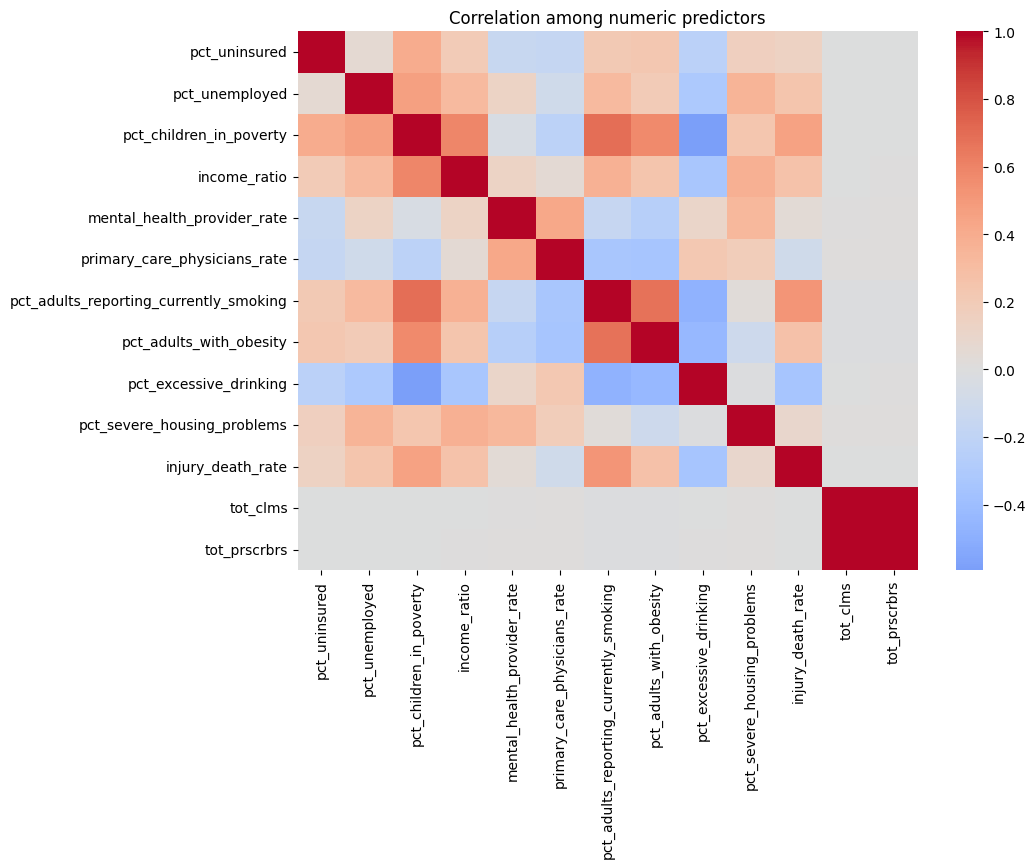

Highly correlated → drop: ['tot_prscrbrs']


In [83]:
# ----- 5. Correlation filter -----
corr = X.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation among numeric predictors")
plt.show()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
drop_cols = [c for c in upper.columns if any(upper[c].abs()>0.9)]
print("Highly correlated → drop:", drop_cols)
X = X.drop(columns=drop_cols, errors="ignore")


Top features by F-test:
                                    Feature      F_score        p_value
2                  pct_children_in_poverty  5227.167480   0.000000e+00
8                   pct_excessive_drinking  4528.659858   0.000000e+00
6   pct_adults_reporting_currently_smoking  3321.748037   0.000000e+00
3                             income_ratio  2177.996220   0.000000e+00
10                       injury_death_rate  2114.438684   0.000000e+00
0                            pct_uninsured  1782.208467   0.000000e+00
7                  pct_adults_with_obesity  1161.451965  4.055300e-254
1                           pct_unemployed   363.850667   4.518936e-81
9              pct_severe_housing_problems   216.937792   4.365383e-49
4              mental_health_provider_rate    21.726794   3.144928e-06


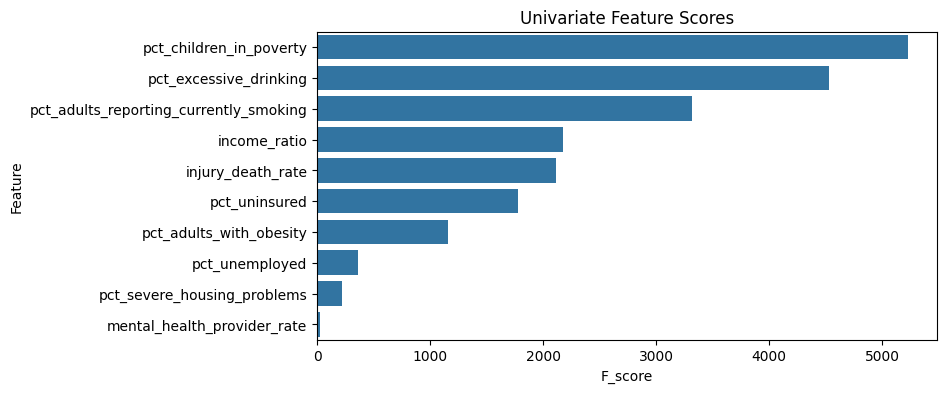

In [84]:
# ----- 6. Univariate filter (SelectKBest) -----
selector = SelectKBest(score_func=f_regression, k="all")
selector.fit(X, y)
scores = pd.DataFrame({
    "Feature": X.columns,
    "F_score": selector.scores_,
    "p_value": selector.pvalues_
}).sort_values(by="F_score", ascending=False)
print("\nTop features by F-test:\n", scores.head(10))

plt.figure(figsize=(8,4))
sns.barplot(x="F_score", y="Feature", data=scores.head(10))
plt.title("Univariate Feature Scores")
plt.show()

In [96]:
# ----- 7. Recursive Feature Elimination (Wrapper) -----
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=8)
rfe.fit(X, y)
selected_rfe = X.columns[rfe.support_]
print("\nRFE selected features:", selected_rfe.tolist())


RFE selected features: ['pct_unemployed', 'pct_children_in_poverty', 'income_ratio', 'primary_care_physicians_rate', 'pct_adults_with_obesity', 'pct_excessive_drinking', 'pct_severe_housing_problems', 'tot_clms']


In [86]:
# ----- 8. Embedded method (LASSO) -----
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)
lasso_features = X.columns[np.abs(lasso.coef_) > 0]
print("LASSO selected features:", lasso_features.tolist())

LASSO selected features: ['tot_clms']


In [87]:
# ----- 9. Combine results -----
final_features = list(set(selected_rfe) | set(lasso_features))
print("\nFinal feature set for modeling:", final_features)

X_final = X[final_features]


Final feature set for modeling: ['income_ratio', 'tot_clms', 'pct_severe_housing_problems', 'pct_adults_with_obesity', 'pct_children_in_poverty', 'pct_excessive_drinking', 'primary_care_physicians_rate', 'pct_unemployed']


In [88]:
# ----- 10. Split data -----
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.3, random_state=42
)

In [89]:
# ----- 11. Build preprocessing + model pipeline -----
regression_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

In [98]:
# ----- 12. Train model -----
regression_pipe.fit(X_train, y_train)
y_pred = regression_pipe.predict(X_test)


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(regression_pipe, X, y, cv=kf, scoring='r2')

print("Cross-Validation R² scores:", cv_scores)
print("Mean R²:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))

In [ ]:
train_r2 = regression_pipe.score(X_train, y_train)
test_r2 = regression_pipe.score(X_test, y_test)
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, CV R² Mean: {np.mean(cv_scores):.4f}")

In [91]:
# ----- 13. Evaluate regression -----
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print(f"\nRegression Results:\nR^2 = {r2:.4f}, RMSE = {rmse:,.2f}")



Regression Results:
R^2 = 0.8974, RMSE = 525.07


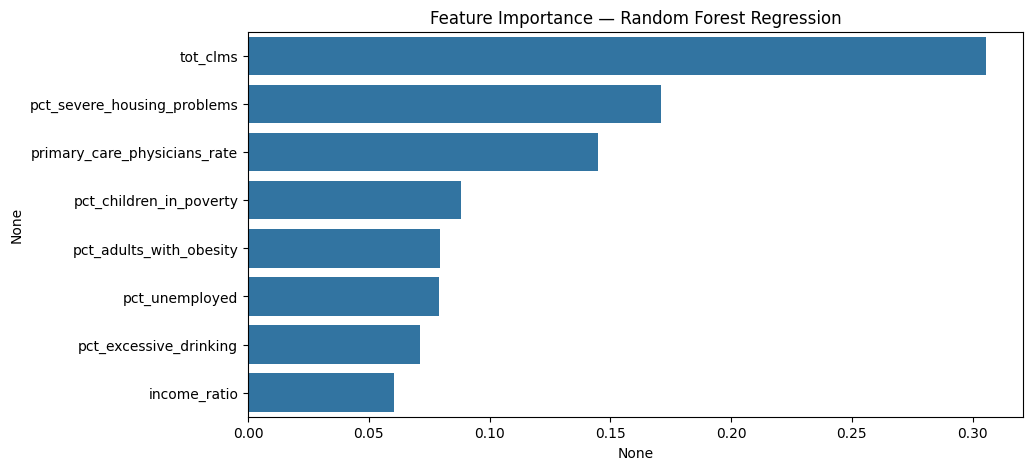

In [97]:
# ----- 14. Feature importance -----
rf_model = regression_pipe.named_steps["model"]
importances = pd.Series(rf_model.feature_importances_, index=X_final.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance — Random Forest Regression")
plt.show()

In [93]:
# ----- 15. Create classification target (high vs low prescribing) -----
median_rate = panel["opioid_prscrbng_rate"].median()
panel["high_burden"] = (panel["opioid_prscrbng_rate"] > median_rate).astype(int)

y_clf = panel.loc[y.index, "high_burden"]

In [94]:
# ----- 16. Split and train classifier -----
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_final, y_clf, test_size=0.3, random_state=42
)

clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)




Classification Accuracy: 0.6805010793882453
F1 Score: 0.6163096397273612

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.73     56335
           1       0.64      0.60      0.62     42332

    accuracy                           0.68     98667
   macro avg       0.67      0.67      0.67     98667
weighted avg       0.68      0.68      0.68     98667



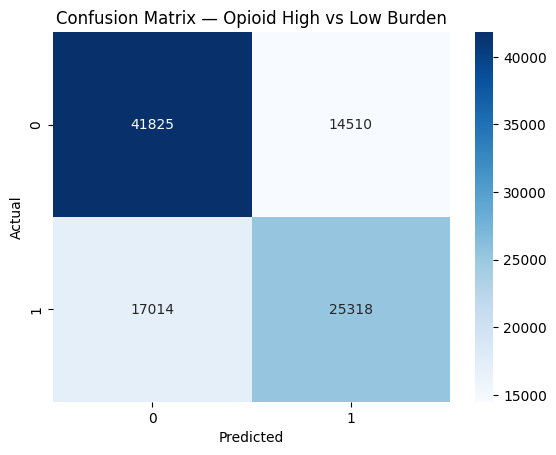

In [95]:
# ----- 17. Evaluate classifier -----
print("\nClassification Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("F1 Score:", f1_score(y_test_c, y_pred_c))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_c))

sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Opioid High vs Low Burden")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()